In [68]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

In [70]:
data = (pd.read_csv("rates_world.csv"))
data.fillna(0,inplace=True)

data.query("china").head()

,year,region,fertrate,china,after_treatment
0,1960,1,5.756,True,False
1,1961,1,5.905,True,False
2,1962,1,6.062,True,False
3,1963,1,6.206,True,False
4,1964,1,6.320,True,False


In [83]:
data = data.dropna()

In [85]:
data.isnull().sum()

year               0
region             0
fertrate           0
china              0
after_treatment    0
dtype: int64

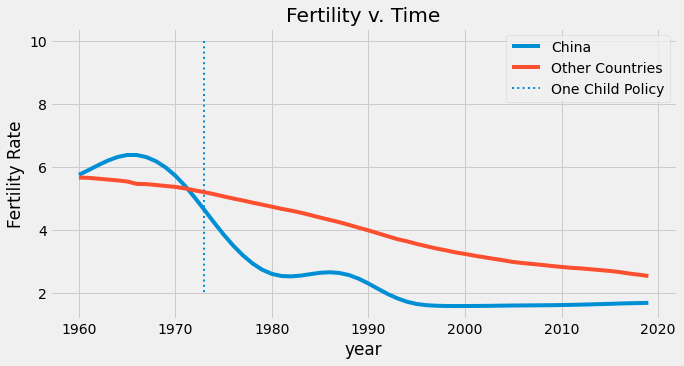

In [71]:
ax = plt.subplot(1, 1, 1)

(data
 .assign(china = np.where(data["china"], "China", "Other Countries"))
 .groupby(["year", "china"])
 ["fertrate"]
 .mean()
 .reset_index()
 .pivot("year", "china", "fertrate")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1973, ymin=10, ymax=2, linestyle=":", lw=2, label="One Child Policy")
plt.ylabel("Fertility Rate")
plt.title("Fertility v. Time")
plt.legend();  

In [72]:
features = ["fertrate"]

inverted = (data.query("~after_treatment") # filter pre-intervention period
            .pivot(index='region', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

region            1      2      3   ...     13     14     15
         year                       ...                     
fertrate 1960  5.756  6.348  5.906  ...  6.880  7.148  6.716
         1961  5.905  6.392  5.902  ...  6.877  7.087  6.696
         1962  6.062  6.425  5.894  ...  6.875  7.020  6.673
         1963  6.206  6.448  5.880  ...  6.872  6.947  6.646
         1964  6.320  6.464  5.859  ...  6.867  6.867  6.615

[5 rows x 15 columns]

In [87]:
inverted.isnull().sum()

region
1     44
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
dtype: int64

In [88]:
inverted = inverted.dropna()

In [89]:
y = inverted[1].values # china
X = inverted.drop(columns=1).values  

In [90]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-1.3000e-02,  8.3950e+00, -5.0000e-03, -5.2050e+00, -1.2139e+01,
       -3.2100e+00,  1.9600e-01,  3.0290e+00,  1.6000e-01, -2.5700e-01,
        1.9000e-02,  2.2470e+00, -2.3000e+00,  9.8280e+00])

In [92]:
china_synth_lr = (data.query("~china")
                  .pivot(index='year', columns="region")["fertrate"]
                  .values.dot(weights_lr))

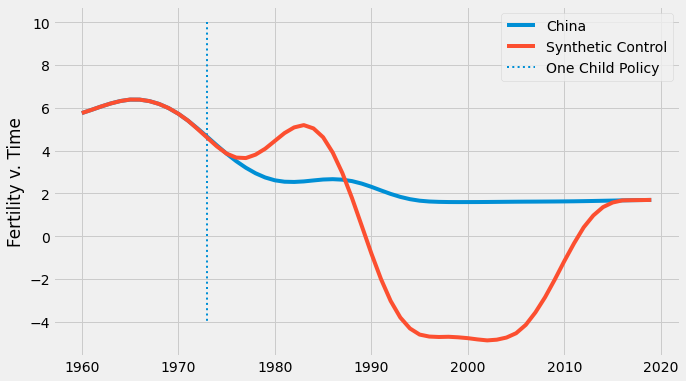

In [100]:
plt.figure(figsize=(10,6))
plt.plot(data.query("china")["year"], data.query("china")["fertrate"], label="China")
plt.plot(data.query("china")["year"], china_synth_lr, label="Synthetic Control")
plt.vlines(x=1973, ymin=10, ymax=-4, linestyle=":", lw=2, label="One Child Policy")
plt.ylabel("Fertility v. Time")
plt.legend();

In [101]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [102]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [103]:
china_weights = get_w(X, y)
print("Sum:", china_weights.sum())
np.round(china_weights, 4)

Sum: 1.0000000000000044


array([0.0051, 0.    , 0.    , 0.    , 0.    , 0.4161, 0.    , 0.5225,
       0.    , 0.    , 0.0564, 0.    , 0.    , 0.    ])

In [104]:
china_synth = data.query("~china").pivot(index='year', columns="region")["fertrate"].values.dot(china_weights)

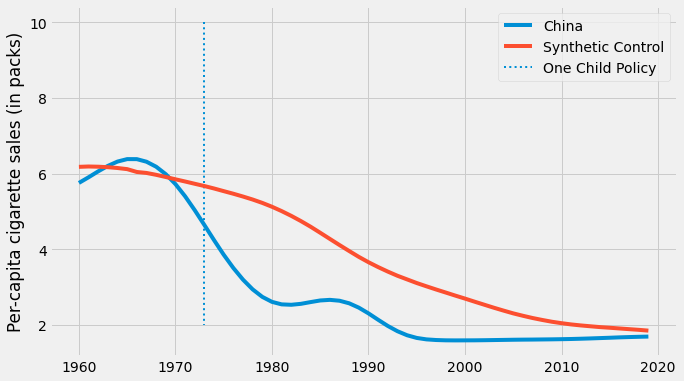

In [105]:
plt.figure(figsize=(10,6))
plt.plot(data.query("china")["year"], data.query("china")["fertrate"], label="China")
plt.plot(data.query("china")["year"], china_synth, label="Synthetic Control")
plt.vlines(x=1973, ymin=10, ymax=2, linestyle=":", lw=2, label="One Child Policy")
plt.ylabel("Fertility Rate")
plt.legend();

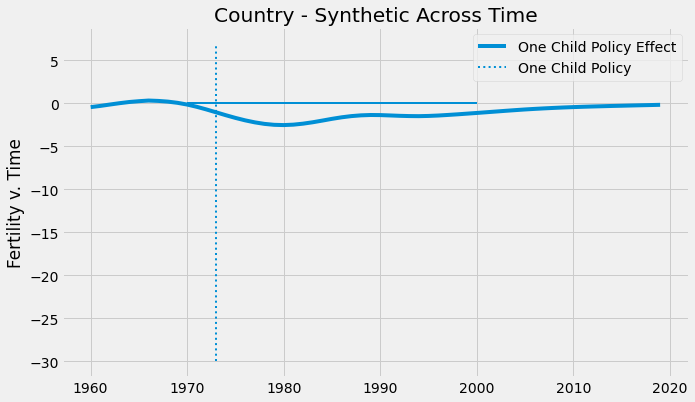

In [108]:
plt.figure(figsize=(10,6))
plt.plot(data.query("china")["year"], data.query("china")["fertrate"] - china_synth,
         label="One Child Policy Effect")
plt.vlines(x=1973, ymin=-30, ymax=7, linestyle=":", lw=2, label="One Child Policy")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("Country - Synthetic Across Time")
plt.ylabel("Fertility v. Time")
plt.legend();

In [113]:
def synthetic_control(region: int, pool: List[int], data: pd.DataFrame) -> np.array:
    
    features = ["fertrate"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='region', columns="year")[features]
                .T)
    
    y = inverted[region].values # treated
    X = inverted.drop(columns=region).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(region=={region})")
                 .pivot(index='year', columns="region")["fertrate"]
                 .values.dot(weights))

    return (data
            .query(f"region=={region}")[["region", "year", "fertrate", "after_treatment"]]
            .assign(synthetic=synthetic))

In [115]:
control_pool = data["region"].unique()

synthetic_control(3, control_pool, data).head()

,region,year,fertrate,after_treatment,synthetic
120,3,1960,5.906,False,5.657000
121,3,1961,5.902,False,5.660286
122,3,1962,5.894,False,5.644429
123,3,1963,5.880,False,5.629500
124,3,1964,5.859,False,5.611643


In [119]:
from joblib import Parallel, delayed

parallel_fn = delayed(partial(synthetic_control, pool=control_pool, data=data))

sinthetic_countries = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [120]:
sinthetic_countries[0].head()

,region,year,fertrate,after_treatment,synthetic
0,1,1960,5.756,False,5.667714
1,1,1961,5.905,False,5.660071
2,1,1962,6.062,False,5.632429
3,1,1963,6.206,False,5.606214
4,1,1964,6.320,False,5.578714


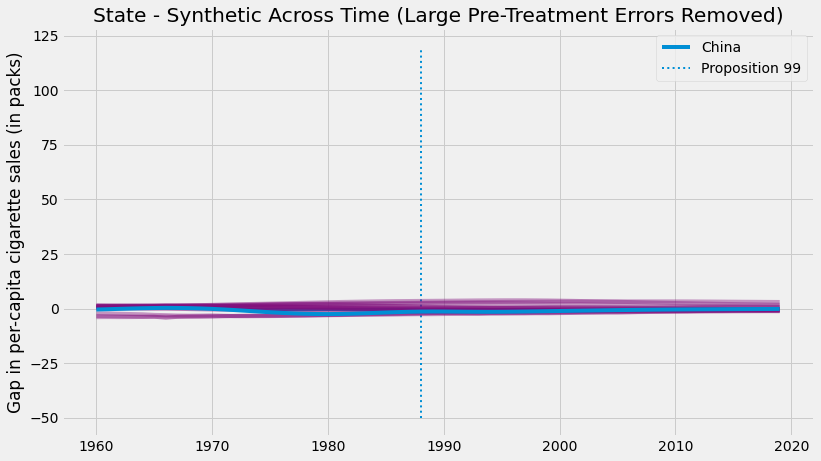

In [124]:
def pre_treatment_error(region):
    pre_treat_error = (region.query("~after_treatment")["fertrate"] 
                       - region.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for region in sinthetic_countries:
    
    # remove units with mean error above 80.
    if pre_treatment_error(region) < 80:
        plt.plot(region["year"], region["fertrate"] - region["synthetic"], color="C5",alpha=0.4)

plt.plot(data.query("china")["year"], data.query("china")["fertrate"] - china_synth,
        label="China");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

In [126]:
china_number = 3

effects = [region.query("year==2000").iloc[0]["fertrate"] - region.query("year==2000").iloc[0]["synthetic"]
           for region in sinthetic_countries
           if pre_treatment_error(region) < 80] # filter out noise

china_effect = data.query("china & year==2000").iloc[0]["fertrate"] - china_synth[-1] 

print("China Treatment Effect for the Year 2000:", china_effect)
np.array(effects)

China Treatment Effect for the Year 2000: -0.2570017357380934


array([-1.6515    , -1.20792857,  0.186     , -1.15864286, -0.67007143,
        2.03528571, -0.89721429,  3.18064286,  0.03385714, -2.08114286,
       -0.4515    , -1.90542857,  3.64885714,  0.72171429,  0.21707143])

In [127]:
np.mean(np.array(effects) < china_effect)

0.5333333333333333

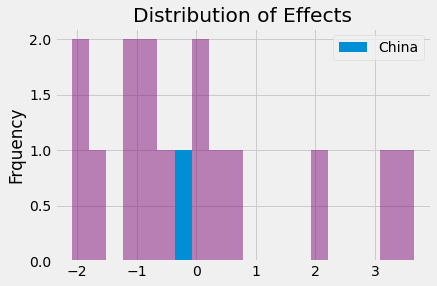

In [128]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([china_effect], bins=bins, color="C0", label="China")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();